# Train a RetinaNet to Detect ElectroMagnetic Signals

**Author:** [lukewood](https://lukewood.xyz), Kevin Anderson, Peter Gerstoft<br>
**Date created:** 2022/08/16<br>
**Last modified:** 2022/08/16<br>
**Description:** Train ...

## Overview

TODO provide an overview of em-loader.

In [1]:
import sys

import keras_cv
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from absl import flags
from keras_cv import bounding_box
from tensorflow import keras
from tensorflow.keras import callbacks as callbacks_lib
from tensorflow.keras import optimizers
from luketils import artifacts
import em_loader
import wandb
from luketils import visualization

batch_size = 8
epochs = 1

ground_truth_mapping = [
    "Ground Truth",
]
ground_truth_mapping = dict(zip(range(len(ground_truth_mapping)), ground_truth_mapping))

prediction_mapping = [
    "Prediction",
]
prediction_mapping = dict(zip(range(len(prediction_mapping)), prediction_mapping))

In [2]:
checkpoint_path = 'weights/'

In [3]:
import os
artifacts_dir = 'artifacts/naive/'
artifacts.set_base(artifacts_dir)
os.makedirs(artifacts_dir, exist_ok=True)

## Data loading

Great!  Our data is now loaded into the format
`{"images": images, "bounding_boxes": bounding_boxes}`.  This format is supported in all
KerasCV preprocessing components.

Lets load some data and verify that our data looks as we expect it to.

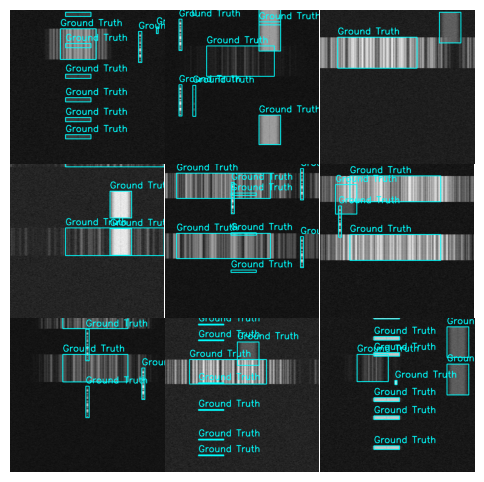

In [4]:
import functools

dataset, dataset_info = em_loader.load(
    split="train",
    bounding_box_format="xywh",
    batch_size=9,
    version=2,
)


example = next(iter(dataset))
images, boxes = example["images"], example["bounding_boxes"]

plot_fn = functools.partial(visualization.plot_bounding_box_gallery, 
    images=images,
    value_range=(0, 255),
    bounding_box_format="xywh",
    y_true=boxes,
    scale=2,
    rows=3,
    cols=3,
    thickness=2,
    font_scale=1,
    class_mapping=ground_truth_mapping,
)
    
plot_fn(path=f"{artifacts_dir}/ground-truth.png")
plot_fn(show=True)

Looks like everything is structured as expected.  Now we can move on to constructing our
data pipeline

In [5]:
# train_ds is batched as a (images, bounding_boxes) tuple
# bounding_boxes are ragged
train_ds, train_dataset_info = em_loader.load(
    bounding_box_format="xywh", split="train", batch_size=batch_size, version=2
)
val_ds, val_dataset_info = em_loader.load(
    bounding_box_format="xywh", split="val", batch_size=batch_size, version=2
)


def unpackage_dict(inputs):
    return inputs["images"], inputs["bounding_boxes"]


train_ds = train_ds.map(unpackage_dict, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(unpackage_dict, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

Our data pipeline is now complete.  We can now move on to model creation and training.

## Model creation

We'll use the KerasCV API to construct a RetinaNet model.  In this tutorial we use
a pretrained ResNet50 backbone using weights.  In order to perform fine-tuning, we
freeze the backbone before training.  When `include_rescaling=True` is set, inputs to
the model are expected to be in the range `[0, 255]`.

In [6]:
model = keras_cv.models.RetinaNet(
    classes=1,
    bounding_box_format="xywh",
    backbone="resnet50",
    backbone_weights="imagenet",
    include_rescaling=True,
    evaluate_train_time_metrics=False,
)

In [7]:
optimizer = tf.optimizers.SGD(global_clipnorm=10.0)
metrics = [
    keras_cv.metrics.COCOMeanAveragePrecision(
        class_ids=range(1),
        bounding_box_format="xywh",
        name="MaP",
    ),
    keras_cv.metrics.COCORecall(
        class_ids=range(1),
        bounding_box_format="xywh",
        max_detections=100,
        name="Recall",
    ),
]

model.compile(
    classification_loss=keras_cv.losses.FocalLoss(from_logits=True, reduction="none"),
    box_loss=keras_cv.losses.SmoothL1Loss(l1_cutoff=1.0, reduction="none"),
    optimizer=optimizer,
    metrics=metrics,
)

All that is left to do is construct some callbacks:

In [8]:
callbacks = [
    callbacks_lib.TensorBoard(log_dir="logs"),
    callbacks_lib.ReduceLROnPlateau(patience=7),
    keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True),
]

And run `model.fit()`!

In [9]:
history = model.fit(
    train_ds,
    validation_data=val_ds.take(20),
    epochs=50,
    callbacks=callbacks,
)

Epoch 1/50
483/483 [==============================] - 82s 141ms/step - loss: 3.3510 - classification_loss: 1.3277 - regularization_loss: 0.0000e+00 - box_loss: 2.0233 - val_MaP: 0.0783 - val_Recall: 0.1225 - val_loss: 2.4689 - val_classification_loss: 1.0069 - val_box_loss: 1.4619 - val_regularization_loss: 0.0000e+00 - lr: 0.0100
Epoch 2/50
483/483 [==============================] - 62s 129ms/step - loss: 1.1975 - classification_loss: 0.3458 - regularization_loss: 0.0000e+00 - box_loss: 0.8517 - val_MaP: 0.1374 - val_Recall: 0.1900 - val_loss: 1.0242 - val_classification_loss: 0.3677 - val_box_loss: 0.6565 - val_regularization_loss: 0.0000e+00 - lr: 0.0100
Epoch 3/50
483/483 [==============================] - 62s 127ms/step - loss: 0.7519 - classification_loss: 0.1737 - regularization_loss: 0.0000e+00 - box_loss: 0.5782 - val_MaP: 0.1315 - val_Recall: 0.1861 - val_loss: 1.0189 - val_classification_loss: 0.3871 - val_box_loss: 0.6318 - val_regularization_loss: 0.0000e+00 - lr: 0.0100
E

Epoch 26/50
483/483 [==============================] - 62s 128ms/step - loss: 0.0351 - classification_loss: 4.6607e-04 - regularization_loss: 0.0000e+00 - box_loss: 0.0347 - val_MaP: 0.2100 - val_Recall: 0.2369 - val_loss: 0.4894 - val_classification_loss: 0.2579 - val_box_loss: 0.2315 - val_regularization_loss: 0.0000e+00 - lr: 0.0100
Epoch 27/50
483/483 [==============================] - 62s 127ms/step - loss: 0.0309 - classification_loss: 4.3514e-04 - regularization_loss: 0.0000e+00 - box_loss: 0.0305 - val_MaP: 0.2127 - val_Recall: 0.2340 - val_loss: 0.4742 - val_classification_loss: 0.2406 - val_box_loss: 0.2336 - val_regularization_loss: 0.0000e+00 - lr: 0.0100
Epoch 28/50
483/483 [==============================] - 62s 128ms/step - loss: 0.0282 - classification_loss: 3.8937e-04 - regularization_loss: 0.0000e+00 - box_loss: 0.0278 - val_MaP: 0.2083 - val_Recall: 0.2379 - val_loss: 0.4730 - val_classification_loss: 0.2368 - val_box_loss: 0.2363 - val_regularization_loss: 0.0000e+00

Epoch 50/50
483/483 [==============================] - 62s 128ms/step - loss: 0.0144 - classification_loss: 2.6712e-04 - regularization_loss: 0.0000e+00 - box_loss: 0.0141 - val_MaP: 0.2111 - val_Recall: 0.2396 - val_loss: 0.4415 - val_classification_loss: 0.2298 - val_box_loss: 0.2117 - val_regularization_loss: 0.0000e+00 - lr: 1.0000e-05


## Model Evaluation

First, lets plot our learning curves

In [10]:
metrics = history.history

In [11]:
', '.join(metrics.keys())

'loss, classification_loss, regularization_loss, box_loss, val_MaP, val_Recall, val_loss, val_classification_loss, val_box_loss, val_regularization_loss, lr'

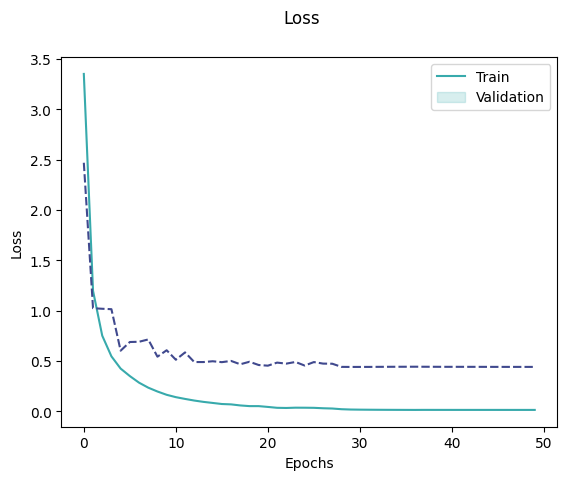

In [12]:
metrics_to_plot = {
    'Train': metrics['loss'],
    'Validation': metrics['val_loss'],
}

plot_fn = functools.partial(visualization.line_plot, data=metrics_to_plot, title='Loss', xlabel='Epochs', ylabel='Loss', transparent=True)
plot_fn(path=f'{artifacts_dir}/loss.png')
plot_fn(show=True)

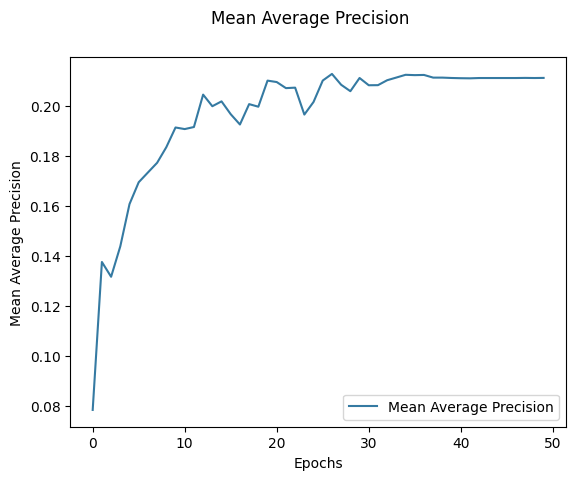

In [13]:
metrics_to_plot = {
    'Mean Average Precision': metrics['val_MaP'],
}

plot_fn = functools.partial(visualization.line_plot, data=metrics_to_plot, title='Mean Average Precision', xlabel='Epochs', ylabel='Mean Average Precision')
plot_fn(path=f'{artifacts_dir}/MaP.png')
plot_fn(show=True)

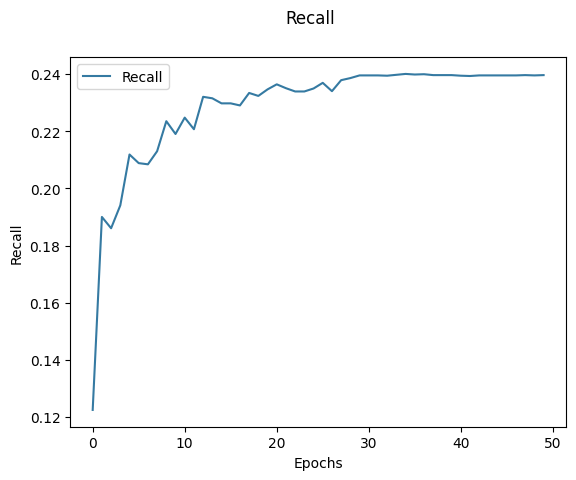

In [14]:
metrics_to_plot = {
    'Recall': metrics['val_Recall'],
}

plot_fn = functools.partial(visualization.line_plot, data=metrics_to_plot, title='Recall', xlabel='Epochs', ylabel='Recall')
plot_fn(path=f'{artifacts_dir}/Recall.png')
plot_fn(show=True)

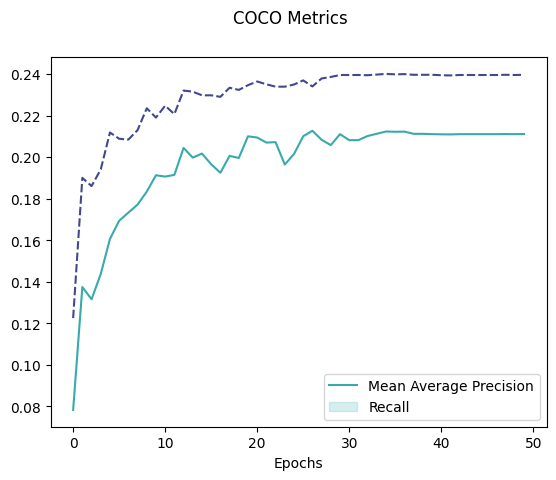

In [15]:
metrics_to_plot = {
    'Mean Average Precision': metrics['val_MaP'],
    'Recall': metrics['val_Recall'],
}

plot_fn = functools.partial(visualization.line_plot, data=metrics_to_plot, title='COCO Metrics', xlabel='Epochs')
plot_fn(path=f'{artifacts_dir}/COCO_Metrics.png')
plot_fn(show=True)

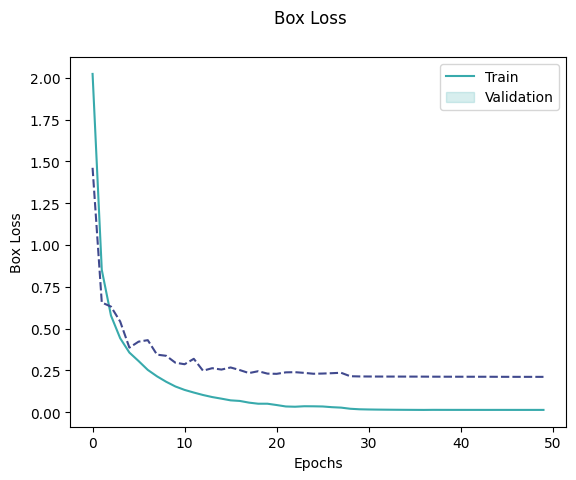

In [16]:
metrics_to_plot = {
    'Train': metrics['box_loss'],
    'Validation': metrics['val_box_loss'],
}

plot_fn = functools.partial(visualization.line_plot, data=metrics_to_plot, title='Box Loss', xlabel='Epochs', ylabel='Box Loss')
plot_fn(path=f'{artifacts_dir}/box_loss.png')
plot_fn(show=True)

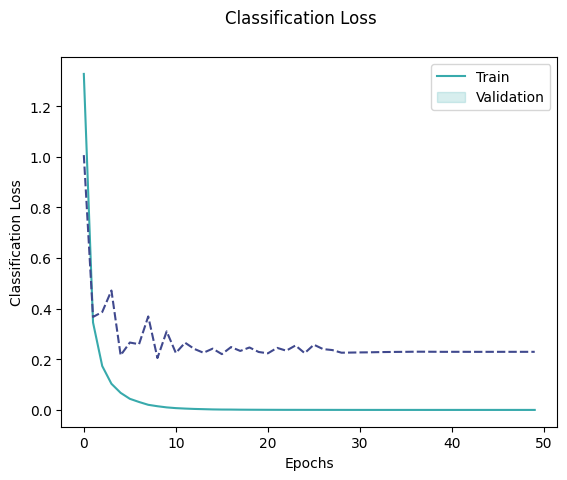

In [17]:
metrics_to_plot = {
    'Train': metrics['classification_loss'],
    'Validation': metrics['val_classification_loss'],
}

plot_fn = functools.partial(visualization.line_plot, data=metrics_to_plot, title='Classification Loss', xlabel='Epochs', ylabel='Classification Loss')
plot_fn(path=f'{artifacts_dir}/classification_loss.png')
plot_fn(show=True)

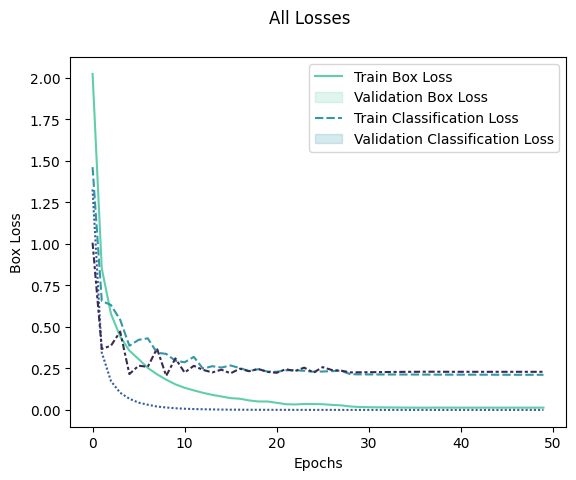

In [18]:
metrics_to_plot = {
    'Train Box Loss': metrics['box_loss'],
    'Validation Box Loss': metrics['val_box_loss'],
    'Train Classification Loss': metrics['classification_loss'],
    'Validation Classification Loss': metrics['val_classification_loss'],
}

plot_fn = functools.partial(visualization.line_plot, data=metrics_to_plot, title='All Losses', xlabel='Epochs', ylabel='Box Loss')
plot_fn(path=f'{artifacts_dir}/all_losses.png')
plot_fn(show=True)

In [19]:
model.load_weights(checkpoint_path)

In [20]:
metrics = model.evaluate(val_ds, return_dict=True)

104/104 [==============================] - 56s 526ms/step - MaP: 0.2127 - Recall: 0.2388 - loss: 0.4644 - classification_loss: 0.2498 - box_loss: 0.2147 - regularization_loss: 0.0000e+00


In [21]:
print("FINAL METRICS:", metrics)

FINAL METRICS: {'MaP': 0.21266870200634003, 'Recall': 0.23878774046897888, 'loss': 0.4644484221935272, 'classification_loss': 0.24978512525558472, 'box_loss': 0.21466335654258728, 'regularization_loss': 0.0}


Lets write our metrics to our artifact directory.

In [22]:
os.makedirs(f'{artifacts_dir}/metrics/', exist_ok=True)
for metric in metrics:
    with open(f"{artifacts_dir}/metrics/{metric}.txt", "w") as f:
        f.write(str(round(metrics[metric], 3)))

Cool, our metrics look pretty reasonable!  

Very low loss, but our MaP and Recall are not that great.  For perspective, in PascalVOC you can expect a MaP of 0.35 in a state of the art workflow - but the loss converges at 2.0 instead of 0.001.  So all in all, we either have an overfitting problem or something else...

For further investigation, lets visualize our detections.

In [23]:
import functools

def visualize_detections(model, split="train"):
    train_ds, val_dataset_info = em_loader.load(
        bounding_box_format="xywh", split=split, batch_size=9
    )
    train_ds = train_ds.map(unpackage_dict, num_parallel_calls=tf.data.AUTOTUNE)
    images, y_true = next(iter(train_ds.take(1)))
    y_pred = model.predict(images)
    
    plot_fn = functools.partial(
        visualization.plot_bounding_box_gallery,
        images,
        value_range=(0, 255),
        bounding_box_format='xywh',
        y_true=y_true,
        y_pred=y_pred,
        scale=2,
        rows=3,
        cols=3,
        thickness=2,
        font_scale=1,
        legend=True,
    )
    plot_fn(
        show=True,
    )
    plot_fn(
        path=f"{artifacts_dir}/{split}.png"
    )

1/1 [==============================] - 3s 3s/step


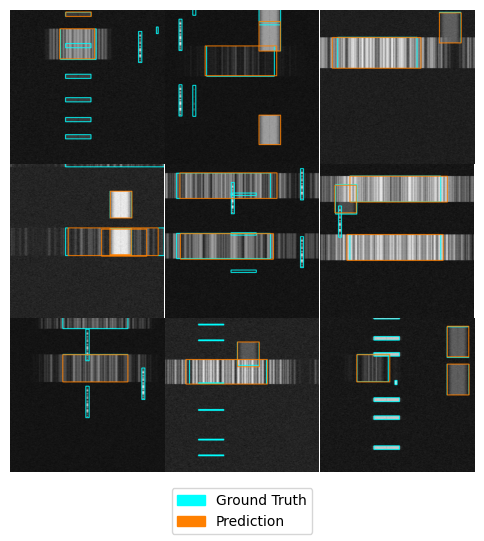

In [24]:
visualize_detections(model, split="train")

1/1 [==============================] - 0s 63ms/step


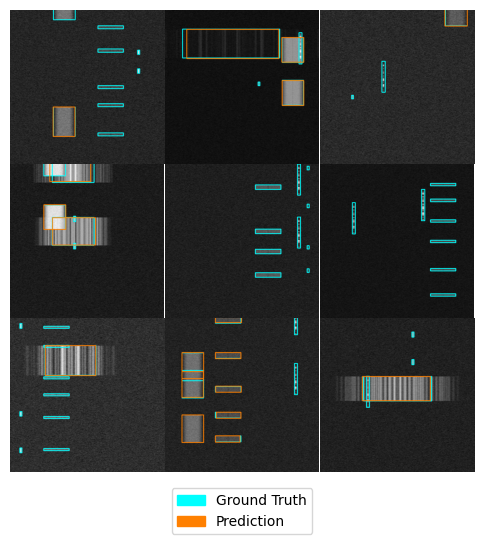

In [25]:
visualize_detections(model, split="val")

Uh oh!  Looks like something is going wrong!  It seems that we are not catching any of the small-skinny, or oblong bounding boxes.

# Conclusion

While the loss converges, we are not able to effectively detect signals in our spectograms.
In part 2, we will dive into why we can't detect the signals and begin solving the issue.
That concludes part one of our notebooks.  To find out why, see part-2 of our notebooks!